# Self Organizing Map

## Importing the libraries

In [1]:
!pip install MiniSom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Importing the dataset

In [2]:
# details about dataset: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

In [3]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,15776156.0,1.0,22.08,11.460,2.0,4.0,4.0,1.585,0.0,0.0,0.0,1.0,2.0,100.0,1213.0
1,15739548.0,0.0,22.67,7.000,2.0,8.0,4.0,0.165,0.0,0.0,0.0,0.0,2.0,160.0,1.0
2,15662854.0,0.0,29.58,1.750,1.0,4.0,4.0,1.250,0.0,0.0,0.0,1.0,2.0,280.0,1.0
3,15687688.0,0.0,21.67,11.500,1.0,5.0,3.0,0.000,1.0,1.0,11.0,1.0,2.0,0.0,1.0
4,15715750.0,1.0,20.17,8.170,2.0,6.0,4.0,1.960,1.0,1.0,14.0,0.0,2.0,60.0,159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223.0,1.0,31.57,10.500,2.0,14.0,4.0,6.500,1.0,0.0,0.0,0.0,2.0,0.0,1.0
686,15769980.0,1.0,20.67,0.415,2.0,8.0,4.0,0.125,0.0,0.0,0.0,0.0,2.0,0.0,45.0
687,15675450.0,0.0,18.83,9.540,2.0,6.0,4.0,0.085,1.0,0.0,0.0,0.0,2.0,100.0,1.0
688,15776494.0,0.0,27.42,14.500,2.0,14.0,8.0,3.085,1.0,1.0,1.0,0.0,2.0,120.0,12.0


In [4]:
# 0 Means application not approved, 1 Approved
pd.DataFrame(y)

,0
0,0
1,0
2,0
3,1
4,1
...,...
685,1
686,0
687,1
688,1


## Feature Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

## Training the SOM

In [6]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

## Visualizing the results

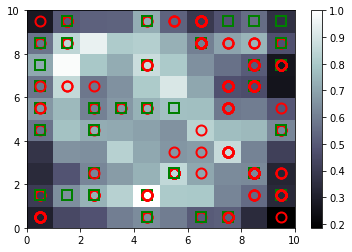

In [7]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T) # different winning nodes on the plane.
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

## Finding the frauds


In [8]:
mappings = som.win_map(X) # contains all the mappings from winning nodes to the customers.
frauds = np.concatenate((mappings[(1,6)], mappings[(4,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

## Printing the Fraud Clients

In [9]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15572390
15586174
15719940
15711742
15761733
15770995
15699963
15736399
15766734
15667934


## Going from Unsupervised to Supervised Deep Learning

In [10]:
# Create Matrix of Features
customers = dataset.iloc[:, 1:].values

In [11]:
# Create Dependent Variable
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

In [12]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

## Building the ANN

In [13]:
# Initializing the ANN
ann = Sequential()

In [14]:
# Adding the input layer and the first hidden layer
ann.add(Dense(units=2, kernel_initializer = 'uniform', activation='relu', input_dim = 15))

# Adding the output layer
ann.add(Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid'))

# Compiling
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
# Training the ANN on the Training set
ann.fit(customers, is_fraud, batch_size = 1, epochs = 2)

Epoch 1/2
690/690 [==============================] - 1s 2ms/step - loss: 0.4426 - accuracy: 0.9855
Epoch 2/2
690/690 [==============================] - 1s 1ms/step - loss: 0.1868 - accuracy: 0.9855


## Predicting test set results

In [16]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['user_id', 'Probability_of_fraud']
y_pred

,user_id,Probability_of_fraud
0,15776156.0,0.022438
1,15739548.0,0.018874
2,15662854.0,0.023896
3,15687688.0,0.311374
4,15715750.0,0.311374
...,...,...
685,15808223.0,0.071326
686,15769980.0,0.012924
687,15675450.0,0.029140
688,15776494.0,0.115835
